---
# Business Probleam
The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

- D_* = Delinquency variables
- 
S_* = Spend variables- 
P_* = Payment variable- s
B_* = Balance variabl- es
R_* = Risk var


with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68

---']iables

# 0.0 Imports

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

#from dtype_diet import report_on_dataframe

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression


# import ydata_profiling as yd
# import sweetviz as sv

warnings.filterwarnings('ignore')

## Helper Functions

In [98]:
def class_metrics(y_true, y_pred):

    f1_score = mt.f1_score(y_true, y_pred)
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred)
    recall = mt.recall_score(y_true, y_pred)
    roc_auc = mt.roc_auc_score(y_true, y_pred)

    return pd.DataFrame({
        'F1 Score':f1_score,
        'Accuracy':accuracy,
        'Precision':precision,
        'Recall':recall,
        'ROC AUC':roc_auc,
        
        
    }, index=[0])

palette = ["#00BFFF", "#DC143C", "#FFA07A", "#FFD700", "#8B008B", "#7CFC00", "#FF69B4", "#00CED1", "#FF6347", "#9400D3"]
def jupyter_settings(palette):
    %matplotlib inline
    plt.style.use( 'seaborn-v0_8' )
    plt.rcParams['figure.figsize'] = [12, 6]
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set(font_scale=2)
    sns.set_theme()
    warnings.simplefilter("ignore")
    # plt.rcParams.update({'font.size': 10})
    sns.set_style("darkgrid")

    
jupyter_settings(palette)

## Load Data

In [46]:
path = 'C:/Users/edils/Documents/amex_dataset/'

train_data = pd.read_parquet(path + 'train.parquet')
#test_data = pd.read_feather(path + 'test_data.ftr')
target = pd.read_csv(path + 'train_labels.csv')
#train_data = pd.merge(train_data, target, on='customer_ID', how='left')

# sample_size = 100000  # Choose the size of the subset you want
# train_data_subset = train_data.sample(n=sample_size, random_state=42)  # Use a fixed random_state for reproducibility
 

In [47]:
# train_data = train_data.fillna(0)

In [48]:
train_data = pd.merge(train_data, target, on='customer_ID', how='left')

In [49]:
# sample_size = 100000  # Choose the size of the subset you want
# train_data_subset = train_data.sample(n=sample_size, random_state=42)  # Use a fixed random_state for reproducibility

# train_data = train_data.dropna()

# 1.0 Data Desciption

In [50]:
df1 = train_data.copy()

In [51]:
df1.sample(50).T

5461234  \
customer_ID  fcbfcfb85938905e7a2f3bcffaafdf4166afcb8ce9c627...   
S_2                                                 2017-03-29   
P_2                                                   0.733272   
D_39                                                         0   
B_1                                                   0.000163   
...                                                        ...   
D_142                                                      NaN   
D_143                                                        0   
D_144                                                 0.009998   
D_145                                                        0   
target                                                       0   

                                                       923068   \
customer_ID  2ac6aa0dfffe70f97ca360a6ff02a703eec1bdc6c10e20...   
S_2                                                 2018-02-08   
P_2                                                   0.525436   
D_39                                                         3   
B_1                                                   0.991681   
...                                                        ...   
D_142                                                      NaN   
D_143                                                        0   
D_144                                                  0.00083   
D_145                                                        0   
target                                                       1   

                                                       5519089  \
customer_ID  ff677e17ccd8054772299105784c661ffceac5463f3bb6...   
S_2                                                 2017-11-13   
P_2                                                   0.933157   
D_39                                                        24   
B_1                                                    0.01427   
...                                                        ...   
D_142                                                      NaN   
D_143                                                        0   
D_144                                                 0.002147   
D_145                                                        0   
target                                                       0   

                                                       4090546  \
customer_ID  bd164be0d2587f6b2d7b76eec3d2d92102b767f0833378...   
S_2                                                 2017-03-23   
P_2                                                   0.932037   
D_39                                                         0   
B_1                                                    0.00875   
...                                                        ...   
D_142                                                      NaN   
D_143                                                        0   
D_144                                                 0.004603   
D_145                                                        0   
target                                                       0   

                                                       1648213  \
customer_ID  4bf0d4d4a6a7e5699d1877dda4dc65161e1102ce22f1e3...   
S_2                                                 2017-07-20   
P_2                                                    0.41006   
D_39                                                         0   
B_1                                                   0.005231   
...                                                        ...   
D_142                                                 0.398695   
D_143                                                        1   
D_144                                                  0.00363   
D_145                                                       15   
target                                                       0   

                                                       3844750  \
customer_ID  b1a9604f66b

## 1.1 Data Shape

In [52]:
df1.shape

(5531451, 191)

## 1.2 Data Info

In [53]:
df1.describe()

KeyboardInterrupt: 

In [ ]:
df1.info()

## 1.3 Check NaNs

In [56]:
df1.isna().sum()

customer_ID    0
S_2            0
P_2            0
D_39           0
B_1            0
              ..
D_142          0
D_143          0
D_144          0
D_145          0
target         0
Length: 191, dtype: int64

In [55]:
df1 = df1.fillna(0)

## 1.4 Check Data Types

In [34]:
df1.dtypes

customer_ID     object
S_2             object
P_2            float32
D_39             int16
B_1            float32
                ...   
D_142          float32
D_143             int8
D_144          float32
D_145             int8
target           int64
Length: 191, dtype: object

## 1.5 Dimensionality Reduction

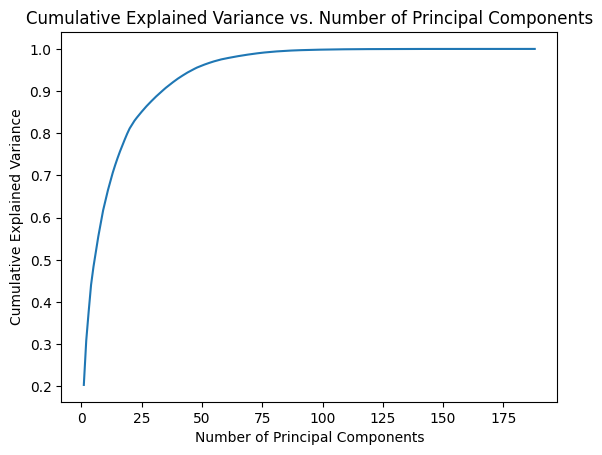

In [66]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Drop columns that you don't want to include in the analysis
X = df1.drop(['customer_ID', 'S_2','target'], axis=1)

# Scale the data using MinMaxScaler
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Get the explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.show()


In [70]:
importance_df = pd.DataFrame({'Column': X.columns, 'Explained Variance Ratio': explained_variance_ratio})
importance_df = importance_df.sort_values(by='Explained Variance Ratio', ascending=False)
importance_df

Column  Explained Variance Ratio
0      P_2              2.033492e-01
1     D_39              1.049811e-01
2      B_1              6.829701e-02
3      B_2              6.391628e-02
4      R_1              4.288692e-02
..     ...                       ...
183  D_141              1.283226e-07
184  D_142              8.028776e-08
185  D_143              4.965122e-08
186  D_144              2.154751e-09
187  D_145              4.617211e-17

[188 rows x 2 columns]

In [71]:
pontos = [5,10,20,25,35,50,75,100,150,170, 188]

for components in pontos:
    print(f"Cumulative Variance for {components} components is {cumulative_variance[components-1]}")

Cumulative Variance for 5 components is 0.4834305638365455
Cumulative Variance for 10 components is 0.6414427319054568
Cumulative Variance for 20 components is 0.811439386842623
Cumulative Variance for 25 components is 0.8511189737088529
Cumulative Variance for 35 components is 0.9077847185677379
Cumulative Variance for 50 components is 0.9605842551519567
Cumulative Variance for 75 components is 0.9910115458474483
Cumulative Variance for 100 components is 0.9983525048801329
Cumulative Variance for 150 components is 0.9999602241079188
Cumulative Variance for 170 components is 0.9999948278094183
Cumulative Variance for 188 components is 0.9999999999999999


In [74]:
target_variance = 0.99
num_components = np.argmax(cumulative_variance >= target_variance) + 1
print(f"Número de componentes para alcançar {target_variance:.2f} de variância cumulativa: {num_components}")

Número de componentes para alcançar 0.99 de variância cumulativa: 74


In [78]:
#selecionar as 74 colunas mais importantes
cols_selected = importance_df.Column.iloc[:74]

# 2.0 Feature Engineering

In [107]:
df2 = df1[cols_selected]
df2['target'] = df1.target
df2['date'] = df1.S_2

In [110]:
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

In [112]:
df2['day'] = df2['date'].dt.day
df2['month'] = df2['date'].dt.month
df2['year'] = df2['date'].dt.year
df2['week'] = df2['date'].dt.isocalendar().week
df2['day_of_week'] = df2['date'].dt.dayofweek





# 2.0 EDA

In [96]:
#Look at the most important columns
correlation_dict = {}

for col in df2.columns:
    if col != 'target':
        correlation = df2[col].corr(df2['target'])
        correlation_dict[col] = correlation
correlation_df = pd.DataFrame(list(correlation_dict.items()), columns=['Coluna', 'Correlação']) 
correlation_df = correlation_df.sort_values(by='Correlação', ascending=False)
correlation_df

Coluna  Correlação
17   D_48    0.527728
24    B_9    0.475858
42   D_58    0.448642
38   D_55    0.448513
10   D_44    0.447288
..    ...         ...
16   D_47   -0.280046
50   D_62   -0.284580
3     B_2   -0.482877
56   B_18   -0.487652
0     P_2   -0.591108

[74 rows x 2 columns]

<Axes: >

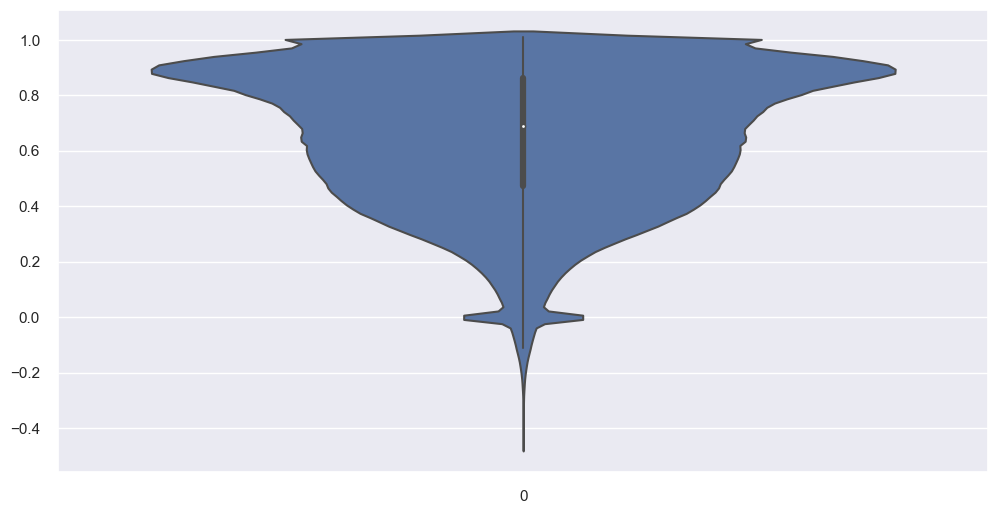

In [100]:
#Look at P_2
sns.violinplot(df2['P_2'])

ValueError: RGBA sequence should have length 3 or 4

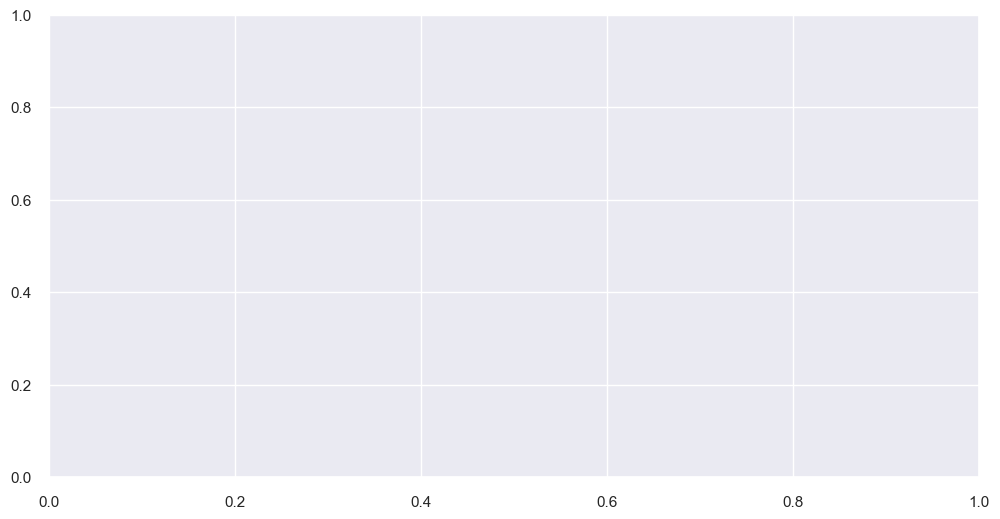

In [105]:
sns.histplot(df2['P_2'])

# 3.0 Preprocessing

In [92]:
mms = MinMaxScaler()

X = df1.drop(['target','customer_ID','S_2'], axis=1)
y = df1.target

X_scaled = mms.fit_transform(X)

# 4.0 Machine Learning

In [93]:
#Split Train-Val
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## 4.1 Random Forest

In [94]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

In [95]:
class_metrics(y_val, y_pred_rf)

F1 Score  Accuracy  Precision    Recall   ROC AUC
0  0.754805   0.87982   0.764696  0.745166  0.834725

## 4.2 XGBoost

In [96]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)

In [97]:
class_metrics(y_val, y_pred_xgb)

F1 Score  Accuracy  Precision    Recall   ROC AUC
0  0.751853   0.87777   0.757868  0.745931  0.833618

## 4.2 Logistic Regression

In [99]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)

In [100]:
class_metrics(y_val, y_pred_lr)

F1 Score  Accuracy  Precision    Recall   ROC AUC
0  0.635972   0.83697   0.713441  0.573679  0.748795